# Connect to DB

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import datetime
import copy
import seaborn as sns
import scipy
import psycopg2

In [7]:
# Set params for all queries
start_date = datetime.datetime(2022, 11, 1)
end_date = datetime.datetime(2022, 11, 14)

# Measuring States & Events

In [3]:
username = input("Username: ")
password = input("Password: ")

# Clear output
from IPython. display import clear_output
clear_output()

In [8]:
conn = psycopg2.connect(
   user = username,
   password = password,
   host = 'replica-state-and-events-development-voxel.a.timescaledb.io',
   port = '11689',
   database = 'production'
)
cursor = conn.cursor()

In [9]:
total_person_sql = """
SELECT 
  date(time),
  SUM(diff) as total_actor_time
FROM (SELECT
  "timestamp" AS "time",
  end_timestamp - timestamp as diff
FROM state_state
WHERE
  timestamp between %s and %s
  and location='chandler'
  and actor_category = 1
ORDER BY 1) as a
GROUP BY 1
ORDER BY 1
"""

total_actor_time = pd.read_sql(total_person_sql, conn, params=[start_date, end_date]);
total_actor_time

,date,total_actor_time
0,2022-11-01,10 days 03:27:46.649000
1,2022-11-02,10 days 07:38:46.223000
2,2022-11-03,10 days 07:22:28.851000
3,2022-11-04,7 days 14:54:16.017000
4,2022-11-05,0 days 21:24:22.426000
5,2022-11-06,0 days 00:03:07.532000
6,2022-11-07,3 days 20:31:01.383000
7,2022-11-08,9 days 05:27:55.967000
8,2022-11-09,10 days 02:12:53.986000
9,2022-11-10,9 days 15:28:58.277000


In [10]:
bad_lift_sql = """
SELECT 
  date(time),
  SUM(diff) as bad_lift_time
FROM (SELECT
  "timestamp" AS "time",
  end_timestamp - timestamp as diff
FROM state_state
WHERE
  timestamp between %s and %s
  and location='chandler'
  and actor_category = 1
  and person_lift_type=2
ORDER BY 1) as a
GROUP BY 1
ORDER BY 1
"""

bad_lift_time = pd.read_sql(bad_lift_sql, conn, params=[start_date, end_date]);
bad_lift_time

,date,bad_lift_time
0,2022-11-01,1 days 23:26:33.269000
1,2022-11-02,1 days 22:42:46.765000
2,2022-11-03,1 days 21:43:40.797000
3,2022-11-04,1 days 09:14:48.433000
4,2022-11-05,0 days 03:53:44.202000
5,2022-11-06,0 days 00:00:17.881000
6,2022-11-07,0 days 18:16:54.150000
7,2022-11-08,1 days 16:03:44.931000
8,2022-11-09,1 days 21:06:02.370000
9,2022-11-10,1 days 18:05:47.619000


In [11]:
bad_reach_sql = """
SELECT 
  date(time),
  SUM(diff) as bad_reach_time
FROM (SELECT
  "timestamp" AS "time",
  end_timestamp - timestamp as diff
FROM state_state
WHERE
  timestamp between %s and %s
  and location='chandler'
  and actor_category = 1
  and person_reach_type=2
ORDER BY 1) as a
GROUP BY 1
ORDER BY 1
"""

bad_reach_time = pd.read_sql(bad_reach_sql, conn, params=[start_date, end_date]);
bad_reach_time

,date,bad_reach_time


In [12]:
all_data = total_actor_time.set_index('date').join(
    bad_lift_time.set_index('date')).join(
    bad_reach_time.set_index('date'))

all_data = all_data.fillna(np.timedelta64(0))
all_data

,total_actor_time,bad_lift_time,bad_reach_time
date,,,
2022-11-01,10 days 03:27:46.649000,1 days 23:26:33.269000,0 days
2022-11-02,10 days 07:38:46.223000,1 days 22:42:46.765000,0 days
2022-11-03,10 days 07:22:28.851000,1 days 21:43:40.797000,0 days
2022-11-04,7 days 14:54:16.017000,1 days 09:14:48.433000,0 days
2022-11-05,0 days 21:24:22.426000,0 days 03:53:44.202000,0 days
2022-11-06,0 days 00:03:07.532000,0 days 00:00:17.881000,0 days
2022-11-07,3 days 20:31:01.383000,0 days 18:16:54.150000,0 days
2022-11-08,9 days 05:27:55.967000,1 days 16:03:44.931000,0 days
2022-11-09,10 days 02:12:53.986000,1 days 21:06:02.370000,0 days


# Measuring Incidents

In [13]:
username = input("Username: ")
password = input("Password: ")

# Clear output
from IPython. display import clear_output
clear_output()

In [14]:
conn = psycopg2.connect(
   user = username,
   password = password,
   host = 'portal-production-postgres.c1trxszive18.us-west-2.rds.amazonaws.com',
   port = '5432',
   database = 'portal_production_postgres'
)
cursor = conn.cursor()

In [15]:
bad_posture_incidents_sql = """
SELECT
  date(timestamp) as date,
  count(*) as bad_posture_count
FROM  
(SELECT
  timestamp,
  incident_type_id,
  zones.name as zone_name,
  api_incidenttype.name
FROM api_incident
INNER JOIN zones on zone_id=zones.id
INNER JOIN api_incidenttype on incident_type_id=api_incidenttype.id
WHERE
  timestamp between %s and %s
  and zones.name='Chandler'
  and incident_type_id = 7
ORDER BY timestamp
) AS a
GROUP BY date
"""

bad_posture_incidents = pd.read_sql(bad_posture_incidents_sql, conn, params=[start_date, end_date]);
bad_posture_incidents

,date,bad_posture_count
0,2022-11-01,384
1,2022-11-02,318
2,2022-11-03,265
3,2022-11-04,261
4,2022-11-05,11
5,2022-11-07,109
6,2022-11-08,245
7,2022-11-09,277
8,2022-11-10,252
9,2022-11-11,205


In [16]:
bad_reach_incidents_sql = """
SELECT
  date(timestamp) as date,
  count(*) as bad_reach_count
FROM  
(SELECT
  timestamp,
  incident_type_id,
  zones.name as zone_name,
  api_incidenttype.name
FROM api_incident
INNER JOIN zones on zone_id=zones.id
INNER JOIN api_incidenttype on incident_type_id=api_incidenttype.id
WHERE
  timestamp between %s and %s
  and zones.name='Chandler'
  and incident_type_id = 15
ORDER BY timestamp
) AS a
GROUP BY date
"""

bad_reach_incidents = pd.read_sql(bad_reach_incidents_sql, conn, params=[start_date, end_date]);
bad_reach_incidents

,date,bad_reach_count
0,2022-11-01,116
1,2022-11-02,122
2,2022-11-03,120
3,2022-11-04,75
4,2022-11-05,2
5,2022-11-06,1
6,2022-11-07,98
7,2022-11-08,116
8,2022-11-09,139
9,2022-11-10,126


In [17]:
all_data = all_data.join(
    bad_posture_incidents.set_index('date')).join(
    bad_reach_incidents.set_index('date'))

all_data.bad_posture_count = all_data.bad_posture_count.fillna(0).astype(int)
all_data.bad_reach_count = all_data.bad_reach_count.fillna(0).astype(int)
all_data

,total_actor_time,bad_lift_time,bad_reach_time,bad_posture_count,bad_reach_count
date,,,,,
2022-11-01,10 days 03:27:46.649000,1 days 23:26:33.269000,0 days,384,116
2022-11-02,10 days 07:38:46.223000,1 days 22:42:46.765000,0 days,318,122
2022-11-03,10 days 07:22:28.851000,1 days 21:43:40.797000,0 days,265,120
2022-11-04,7 days 14:54:16.017000,1 days 09:14:48.433000,0 days,261,75
2022-11-05,0 days 21:24:22.426000,0 days 03:53:44.202000,0 days,11,2
2022-11-06,0 days 00:03:07.532000,0 days 00:00:17.881000,0 days,0,1
2022-11-07,3 days 20:31:01.383000,0 days 18:16:54.150000,0 days,109,98
2022-11-08,9 days 05:27:55.967000,1 days 16:03:44.931000,0 days,245,116
2022-11-09,10 days 02:12:53.986000,1 days 21:06:02.370000,0 days,277,139


# Comparisons

In [18]:
to_timedelta = np.vectorize(lambda x: np.timedelta64(x, 's'))

all_data['lift_compliance'] = 1-all_data.bad_lift_time / all_data.total_actor_time
all_data['reach_compliance'] = 1-all_data.bad_reach_time / all_data.total_actor_time
all_data['lift_compliance_count'] = 1-to_timedelta(all_data.bad_posture_count) / all_data.total_actor_time
all_data['reach_compliance_count'] = 1-to_timedelta(all_data.bad_reach_count) / all_data.total_actor_time
all_data

,total_actor_time,bad_lift_time,bad_reach_time,bad_posture_count,bad_reach_count,lift_compliance,reach_compliance,lift_compliance_count,reach_compliance_count
date,,,,,,,,,
2022-11-01,10 days 03:27:46.649000,1 days 23:26:33.269000,0 days,384,116,0.805134,1.0,0.999562,0.999868
2022-11-02,10 days 07:38:46.223000,1 days 22:42:46.765000,0 days,318,122,0.811372,1.0,0.999643,0.999863
2022-11-03,10 days 07:22:28.851000,1 days 21:43:40.797000,0 days,265,120,0.815147,1.0,0.999702,0.999865
2022-11-04,7 days 14:54:16.017000,1 days 09:14:48.433000,0 days,261,75,0.818229,1.0,0.999604,0.999886
2022-11-05,0 days 21:24:22.426000,0 days 03:53:44.202000,0 days,11,2,0.818015,1.0,0.999857,0.999974
2022-11-06,0 days 00:03:07.532000,0 days 00:00:17.881000,0 days,0,1,0.904651,1.0,1.000000,0.994668
2022-11-07,3 days 20:31:01.383000,0 days 18:16:54.150000,0 days,109,98,0.802396,1.0,0.999673,0.999706
2022-11-08,9 days 05:27:55.967000,1 days 16:03:44.931000,0 days,245,116,0.819103,1.0,0.999693,0.999855
2022-11-09,10 days 02:12:53.986000,1 days 21:06:02.370000,0 days,277,139,0.813799,1.0,0.999682,0.999841


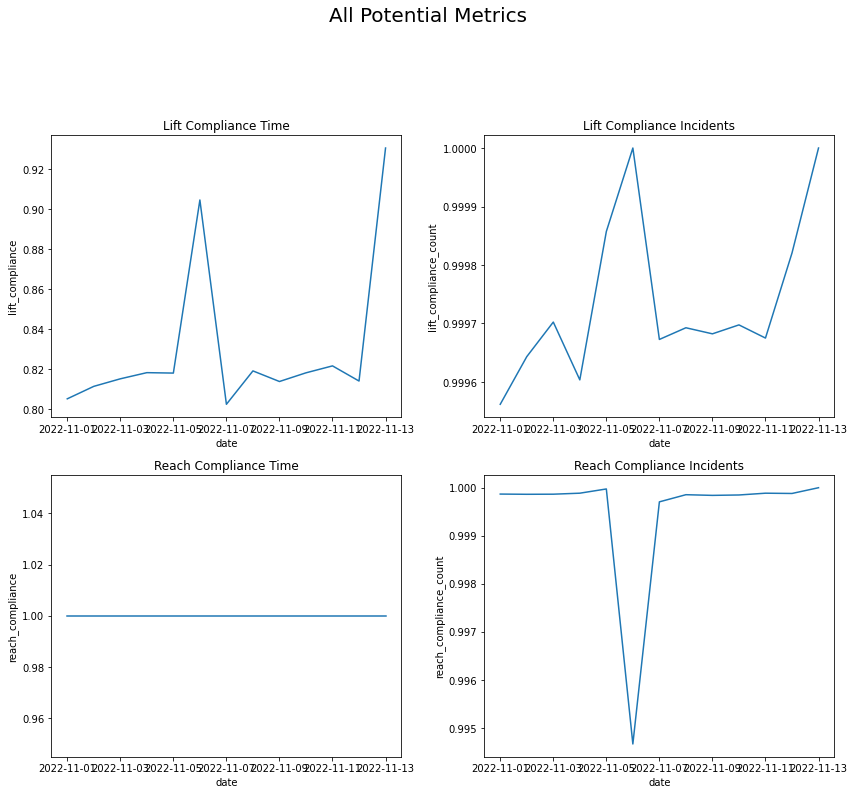

In [19]:
# do plotting
fig, ax = plt.subplots(2,2, figsize=(12,10))

sns.lineplot(all_data.lift_compliance, ax=ax[0][0]).set(title='Lift Compliance Time')
sns.lineplot(all_data.lift_compliance_count, ax=ax[0][1]).set(title='Lift Compliance Incidents')
sns.lineplot(all_data.reach_compliance, ax=ax[1][0]).set(title='Reach Compliance Time')
sns.lineplot(all_data.reach_compliance_count, ax=ax[1][1]).set(title='Reach Compliance Incidents')

fig.suptitle('All Potential Metrics', position=(.5,1.1), fontsize=20)
fig.tight_layout()

fig.show()